In [11]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
import matplotlib as plt

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")  # Path to the compressed dataset

    if not tarball_path.is_file():  # If the file doesn't exist locally
        Path("datasets").mkdir(parents=True, exist_ok=True)  # Create the 'datasets' directory if needed

        url = "https://github.com/ageron/data/raw/main/housing.tgz"  # URL to download the dataset
        urllib.request.urlretrieve(url, tarball_path)  # Download the .tgz file from the URL and save it locally

        with tarfile.open(tarball_path) as housing_tarball:  # Open the .tgz file as a tar archive
            housing_tarball.extractall(path="datasets")  # Extract all contents into the 'datasets' directory

    return pd.read_csv(Path("datasets/housing/housing.csv"))  # Load the CSV data into a DataFrame and return it

housing = load_housing_data()

In [12]:
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5]
)


from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(
    housing,
    test_size=0.2,
    stratify=housing["income_cat"],
    random_state=42
)

housing = strat_train_set.copy()

In [13]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median") # set imputer
housing_num = housing.select_dtypes(include=[np.number])

---
### Log Computation

* When a feature has a **heavy tail** (i.e., extreme values are not exponentially rare), applying **min-max scaling** or **standardization** directly can squash most of the values into a narrow range. This distorts the feature and makes it hard for models to learn useful patterns.

* To fix this, we **first transform the feature** to reduce the skewness and bring the distribution closer to a **symmetric or Gaussian shape**. One common technique for **positive features with heavy right tails** (like population) is to apply a **logarithmic transformation**. 

For example, a population feature that follows a **power law distribution**—where large values are more common than in a Gaussian—benefits significantly from this transformation. After taking the log, the feature distribution becomes bell-shaped and easier for models to work with.

**Note**: Only apply `np.log()` to **positive values**; for values that include zero, consider using `np.log1p()` instead.


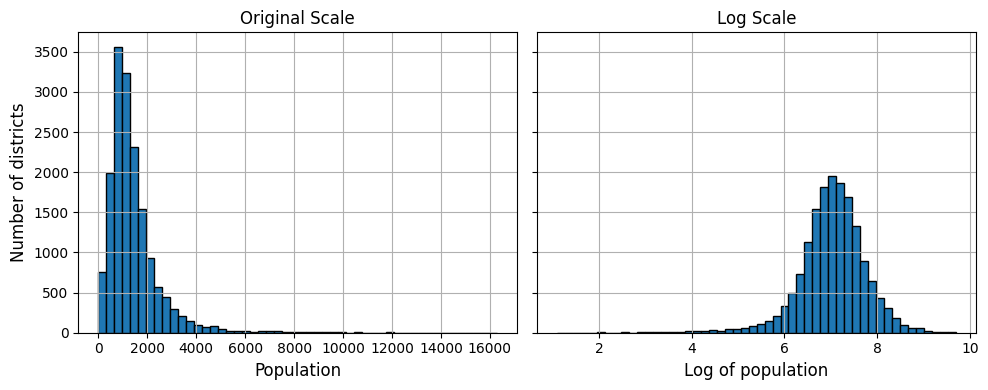

In [15]:
import matplotlib.pyplot as plt  # Make sure you import like this
import numpy as np

# Create the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Plot histograms
housing["population"].hist(ax=axs[0], bins=50, edgecolor='black')
housing["population"].apply(np.log).hist(ax=axs[1], bins=50, edgecolor='black')

# Set labels
axs[0].set_xlabel("Population", fontsize=12)
axs[1].set_xlabel("Log of population", fontsize=12)
axs[0].set_ylabel("Number of districts", fontsize=12)

# Add titles
axs[0].set_title("Original Scale", fontsize=12)
axs[1].set_title("Log Scale", fontsize=12)

# Adjust layout
plt.tight_layout()

# Save and show
plt.savefig("long_tail_plot.png", dpi=300, bbox_inches='tight')  # Using plt.savefig directly
plt.show()

---
### Bucketizing (Binning)

Bucketizing transforms a **continuous feature** into **categorical intervals** (bins). It's particularly helpful when dealing with:
- **Heavy-tailed features**: Converts uneven distributions into more uniform ones.
- **Multimodal features** (i.e., features with multiple peaks): Allows the model to handle each mode differently.

There are two main strategies:

1. **Equal-size buckets** (e.g., percentiles): Converts the feature to a near-uniform distribution, making further scaling unnecessary.
2. **Multimodal bucketing**: Assigns bucket IDs based on natural peaks. These IDs can be treated as **categories** (e.g., with OneHotEncoding), allowing the model to learn rules specific to different value ranges.

For example, if homes built ~35 years ago are cheaper due to outdated styles, using bucket IDs lets a regression model detect this pattern.

**Note**: Avoid using too many bins with OneHotEncoder to keep the model complexity reasonable.


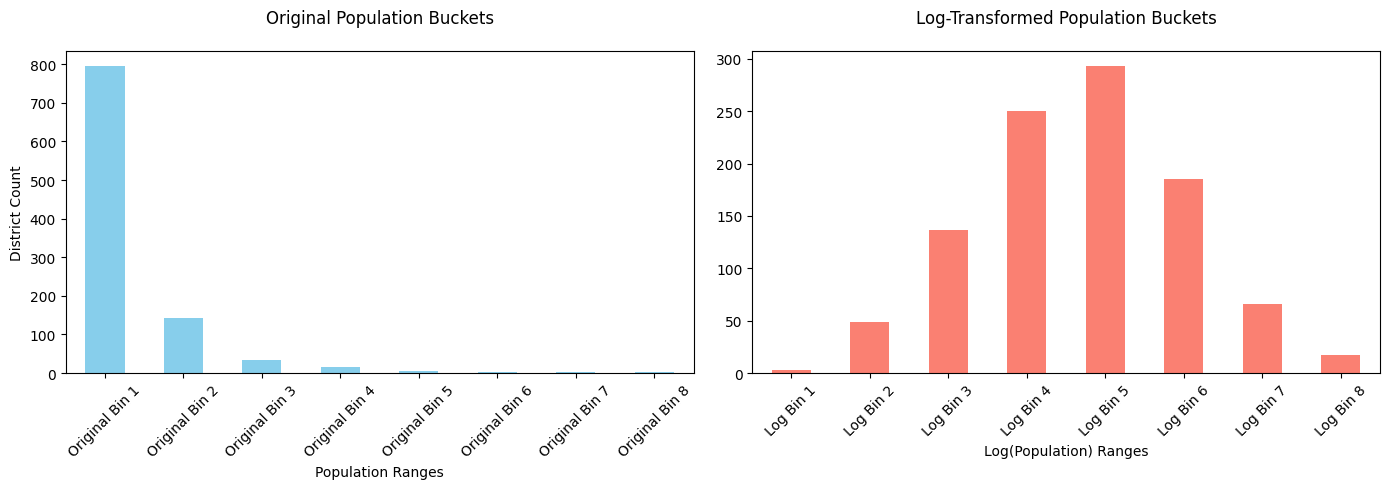


Original Scale Bin Ranges:
population
(0.458, 45.833]       795
(45.833, 90.848]      143
(90.848, 135.864]      34
(135.864, 180.879]     16
(180.879, 225.894]      5
(225.894, 270.909]      3
(270.909, 315.925]      2
(315.925, 360.94]       2
Name: count, dtype: int64

Log Scale Bin Ranges:
population
(-0.207, 0.56]      3
(0.56, 1.321]      49
(1.321, 2.083]    137
(2.083, 2.844]    250
(2.844, 3.605]    293
(3.605, 4.366]    185
(4.366, 5.127]     66
(5.127, 5.889]     17
Name: count, dtype: int64


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Create sample data (replace with your actual housing data)
housing = pd.DataFrame({
    'population': np.random.lognormal(mean=3, sigma=1, size=1000)
})

# 2. Bucketizing parameters
NUM_BINS = 8

# 3. Original scale bucketizing
original_bins = pd.cut(housing['population'], 
                      bins=NUM_BINS,
                      labels=[f'Original Bin {i+1}' for i in range(NUM_BINS)])

# 4. Log scale bucketizing (completely separate processing)
log_pop = np.log(housing['population'])
log_bins = pd.cut(log_pop,
                 bins=NUM_BINS,
                 labels=[f'Log Bin {i+1}' for i in range(NUM_BINS)])

# 5. Create separate visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Original scale plot
original_bins.value_counts().sort_index().plot.bar(ax=ax1, color='skyblue')
ax1.set_title('Original Population Buckets', pad=20)
ax1.set_xlabel('Population Ranges')
ax1.set_ylabel('District Count')
ax1.tick_params(axis='x', rotation=45)

# Log scale plot
log_bins.value_counts().sort_index().plot.bar(ax=ax2, color='salmon')
ax2.set_title('Log-Transformed Population Buckets', pad=20)
ax2.set_xlabel('Log(Population) Ranges')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 6. Optional: Show bin boundaries
print("\nOriginal Scale Bin Ranges:")
print(pd.cut(housing['population'], bins=NUM_BINS).value_counts().sort_index())

print("\nLog Scale Bin Ranges:")
print(pd.cut(log_pop, bins=NUM_BINS).value_counts().sort_index())

---
### Gaussian RBF (Radial Basis Function)

Multimodal features (with multiple peaks) can be transformed using **Gaussian RBF kernels**. Instead of hard-cutting values into bins, this approach creates a **smooth similarity score** between a value and a reference point (like a known mode).

The formula is:

\\[
\\{RBF}(x, c) = e^{-\\gamma (x - c)^2}
\\]

Where:
- \\( x \\) is the feature value  
- \\( c \\) is the reference point (e.g., 35 years)  
- \\( \\gamma \\) (gamma) controls how quickly the similarity score fades with distance from \\( c \\)

This transformation helps models detect patterns around specific values. For instance, if houses built ~35 years ago affect prices differently, a similarity score to 35 (computed via `rbf_kernel`) allows the model to learn this impact smoothly.

**Note**: A smaller gamma makes the similarity peak wider and less specific; tuning gamma is key for optimal results.
